<a href="https://colab.research.google.com/github/doctorpeppercokebear/image_classification/blob/main/Resnet50v2_squared_all_5class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# precision > 0.7 이하인 클래스 삭제하고 분류 모델 제작

**class label**  
결막염, 비궤양성각막질환, 색소침착성각막염, 안검내반증, 안검염, 유루증

* **batch size**:  62 -> 32
* **learning_rat:e** 5e-4 -> 1e-4
* **Drop out:**  10% -> 40%
* **callback:**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 그래프 한글 안 깨지게 하는 코드

In [ ]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/반려 동물 질병 검사 애플리케이션 /D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

### 모듈 불러오기


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, AveragePooling2D, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # 모델 저장, 조기종료

import matplotlib.pyplot as plt
import numpy as np
import os
# import cv2

# import splitfolders


## 데이터 전처리

### 데이터 압축풀기



```
classes_labels= [
    '궤양성각막질환',
    '백내장',
    '안검종양',
    '핵경화',
    '정상'
]

```

위 라벨만 남기고 삭제 후 학습 진행


In [ ]:
!unzip -q "/content/drive/MyDrive/반려 동물 질병 검사 애플리케이션 /개_안구_all_ttv_au_under_250000_5class.zip"

In [ ]:
import os

base_dir = '/content/content/개_안구_all_ttv_au_under_250000_5class'

for root, dirs, files in os.walk(base_dir):
    if root != base_dir:  # base_dir 자체는 제외
        num_images = sum(1 for file in files if file.endswith('.jpg') or file.endswith('.png'))  # jpg, png 이미지 확인
        print(f"{os.path.basename(root)}: {num_images} images")

test: 0 images
안검종양: 540 images
정상: 8515 images
궤양성각막질환: 1547 images
핵경화: 1081 images
백내장: 2322 images
train: 0 images
안검종양: 25000 images
정상: 25000 images
궤양성각막질환: 25000 images
핵경화: 25000 images
백내장: 25000 images
val: 0 images
안검종양: 538 images
정상: 8513 images
궤양성각막질환: 1545 images
핵경화: 1079 images
백내장: 2321 images


In [ ]:
import os

base_dir = '/content/content/개_안구_all_ttv_au_under_250000_5class/train'

for root, dirs, files in os.walk(base_dir):
    if root != base_dir:  # base_dir 자체는 제외
        num_images = sum(1 for file in files if file.endswith('.jpg') or file.endswith('.png'))  # jpg, png 이미지 확인
        print(f"{os.path.basename(root)}: {num_images} images")

안검종양: 25000 images
정상: 25000 images
궤양성각막질환: 25000 images
핵경화: 25000 images
백내장: 25000 images


### 하이퍼파라미터 설정



In [ ]:
batch_size = 32
img_size = 224
learning_rate = 1e-4    # 기존 5e-4 에서 1e-4로 조절
epochs = 40


classes_labels= [
    '궤양성각막질환',
    '백내장',
    '안검종양',
    '정상',
    '핵경화',
]

num_classes = len(classes_labels)
base_dir = 'content/개_안구_all_ttv_au_under_250000_5class'

### 이미지 증강

In [ ]:
# 이미지 증강이 적용된 데이터 제너레이터 선언
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,         # 이미지를 무작위로 20도까지 회전
    width_shift_range=0.2,     # 가로 이동 범위를 20%로 늘림
    height_shift_range=0.2,    # 세로 이동 범위를 20%로 늘림
    shear_range=0.2,           # 이미지를 20% 범위 내에서 엇갈리게 변형
    zoom_range=0.2,            # 확대/축소 범위를 20%로 늘림
    horizontal_flip=True,
    brightness_range=[0.8, 1.2] # 밝기를 80% ~ 120% 범위에서 무작위 조절
)

validation_datagen = ImageDataGenerator(
    rescale=1. / 255,          # 검증 데이터에도 동일한 정규화 적용
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255          # 테스트 데이터에도 동일한 정규화 적용
)

# flow_from_directory: 디렉토리에서 이미지를 불러와 배치 단위로 제공
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),  # 훈련 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical',        # 다중 클래스 분류이므로 'categorical' 설정
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),    # 검증 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical',        # 다중 클래스 분류이므로 'categorical' 설정
    follow_links=True        # 숨김 파일 무시
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),   # 테스트 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical'         # 다중 클래스 분류이므로 'categorical' 설정
)


Found 125036 images belonging to 5 classes.
Found 13996 images belonging to 5 classes.
Found 14006 images belonging to 5 classes.


### 이미지 확인

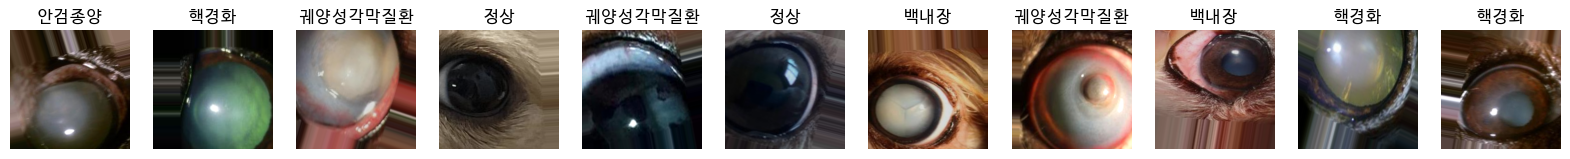

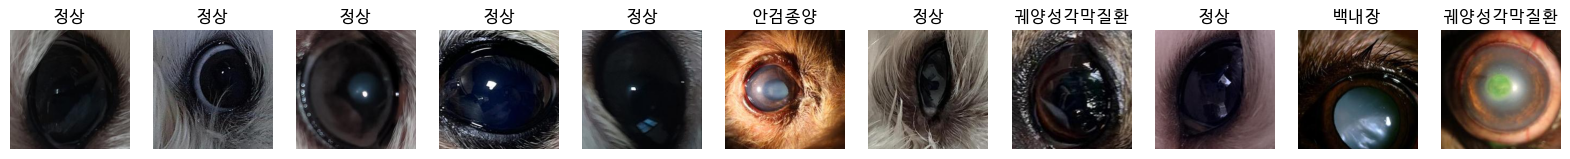

In [ ]:
def show_images(generator, num_images=11):
    image, labels = next(generator)
    plt.figure(figsize=(20, 20))  # 이미지 개수에 따라 figsize 조절

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[i])

        # 클래스 레이블에 맞는 제목 설정
        class_index = np.argmax(labels[i])  # one-hot encoded labels에서 클래스 인덱스 추출

        # Check if class_index is within the range of classes_labels
        if class_index >= len(classes_labels):
            class_index = 0

        class_name = classes_labels[class_index]
        plt.title(class_name)

        plt.axis('off')
    plt.show()

show_images(train_generator, num_images=11)  # 모든 클래스 이미지 확인
show_images(test_generator, num_images=11)

## 모델 구현
* ResNet50v2 사용


In [ ]:
# 모델 불러오기 및 선언
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(img_size, img_size, 3),  # 입력 이미지 크기 (224x224x3)
    include_top=False,                    # 사전 학습된 모델의 마지막 분류 레이어 제외
    weights='imagenet',                   # ImageNet 데이터셋으로 사전 학습된 가중치 사용
    pooling='avg'                         # 특징 맵을 평균 풀링하여 1차원 벡터로 변환
)

inputs = base_model.input                 # 입력 레이어 설정 (base_model의 입력 사용)
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)  # 128개 노드의 은닉층 추가 (ReLU 활성화 함수 사용)
x = tf.keras.layers.Dropout(0.4)(x)       # 과적합 방지를 위한 드롭아웃 레이어 추가 (기존 10% 드롭아웃 -> 40%로 증가)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)  # 출력 레이어 설정 (클래스 개수만큼 출력 노드, softmax 활성화 함수 사용)

# 모델 정의
model = tf.keras.Model(inputs=inputs, outputs=outputs)  # 입력과 출력을 연결하여 모델 생성

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,827,717 (90.90 MB)

 Trainable params: 23,782,277 (90.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

### 모델 컴파일링


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# 옵티마이저 설정
# Adam 옵티마이저를 설정합니다. learning_rate는 학습률입니다.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 콜백 함수 설정
# 학습 중 특정 조건이 만족되면 호출되는 함수들입니다.
callback = [
    # val_loss를 모니터링하여 개선이 없을 때 학습률을 감소시키는 콜백
    ReduceLROnPlateau(
        monitor='val_loss',  # 모니터할 값
        mode='min',          # 최소화가 목표
        factor=0.1,          # 학습률 감소 비율
        patience=2,          # 개선 없을 때 기다릴 에포크 수
        min_lr=1e-7,         # 학습률의 최솟값
        verbose=1            # 정보 출력 여부
    ),
    # val_loss가 개선될 때마다 모델을 저장하는 콜백
    ModelCheckpoint(
        '/content/drive/MyDrive/PetHealthCheck/dog_eye_model_best.keras',  # 저장 경로
        monitor='val_loss',  # 모니터할 값
        mode='min',          # 최소화가 목표
        save_best_only=True  # 가장 좋은 모델만 저장
    )
]

# 조기 종료 콜백 설정
# val_loss가 개선되지 않으면 조기 종료하여 과대적합을 방지합니다.
early_stopping_cb = EarlyStopping(
    patience=4,              # 개선이 없을 때 기다릴 에포크 수
    restore_best_weights=True,# 가장 좋은 모델의 가중치를 복원
    mode='min',               # 최소화가 목표
    monitor='val_loss'        # 모니터할 값
)

# 모델 컴파일
# 모델을 학습할 수 있도록 설정합니다.
model.compile(
    optimizer=optimizer,      # 설정한 Adam 옵티마이저 사용
    loss='categorical_crossentropy',# 다중 클래스 분류를 위한 손실 함수
    metrics=[                 # 모델의 성능을 평가할 지표들
        'accuracy',           # 정확도
        tf.keras.metrics.Precision(), # 정밀도
        tf.keras.metrics.Recall(),    # 재현율
        tf.keras.metrics.AUC()        # ROC AUC
    ]
)

## 모델 학습'


In [ ]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[callback, early_stopping_cb]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 1613s 400ms/step - accuracy: 0.6651 - auc_5: 0.9114 - loss: 0.8166 - precision_5: 0.7576 - recall_5: 0.5473 - val_accuracy: 0.8357 - val_auc_5: 0.9776 - val_loss: 0.4186 - val_precision_5: 0.8689 - val_recall_5: 0.8075 - learning_rate: 1.0000e-04
Epoch 2/40
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 1537s 393ms/step - accuracy: 0.7605 - auc_5: 0.9552 - loss: 0.5854 - precision_5: 0.8149 - recall_5: 0.6936 - val_accuracy: 0.8733 - val_auc_5: 0.9860 - val_loss: 0.3206 - val_precision_5: 0.8942 - val_recall_5: 0.8554 - learning_rate: 1.0000e-04
Epoch 3/40
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 1539s 394ms/step - accuracy: 0.7861 - auc_5: 0.9636 - loss: 0.5243 - precision_5: 0.8278 - recall_5: 0.7357 - val_accuracy: 0.8933 - val_auc_5: 0.9906 - val_loss: 0.2522 - val_precision_5: 0.9080 - val_recall_5: 0.8791 - learning_rate: 1.0000e-04
Epoch 4/40
3908/3908 ━━━━━━━━━━━━━━━━━━━━ 1541s 394ms/step - accuracy: 0.8039 - auc_5: 0.9696 - loss: 0.4769 - precision_5: 0.8385 - 

## 평가지표


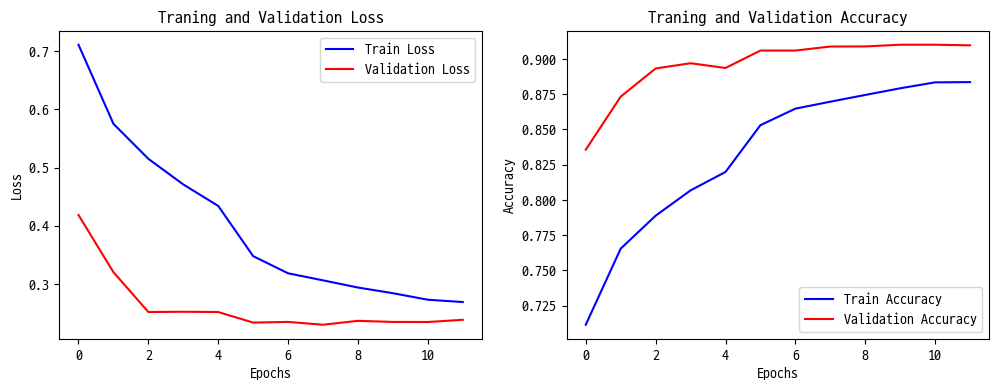

In [ ]:
# 학습 로그 출력
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color="blue")
plt.plot(history.history['val_loss'], label='Validation Loss', color="red")
plt.title('Traning and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color="blue")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color="red")
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# prompt: .h5 모델로 저장하는 코드 알려줘

model.save('/content/drive/MyDrive/PetHealthCheck/dog_eye_model_best_b32_ep12.h5')


In [ ]:
# prompt: /content/drive/MyDrive/CV_project/안구질환_모델/ 이 경로의 모델을 저장하는 코드 알려줘

model.save('/content/drive/MyDrive/PetHealthCheck/Resnet_squared_b64')


In [ ]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/PetHealthCheck/dog_eye_model_best_b32_ep12.h5')

trained_model.evaluate(test_generator)

438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.9064 - auc_5: 0.9929 - loss: 0.2230 - precision_5: 0.9121 - recall_5: 0.9041


[0.2225922793149948,
 0.9073254466056824,
 0.9127178192138672,
 0.904897928237915,
 0.9929313659667969]